# 拟合优化

## 背景

现在版本的程序运行太慢了，需要几分钟的样子。这是在之后的模拟中无法接受的，而且从直觉上来说也不应该需要那么长的运行时间，值得优化的地方很可能是在径迹拟合步骤（因为对比之前的代码，这次多了拟合径迹）。
对于一条径迹的拟合，假设有5个点，考虑最小二乘法的计算，有小于30次加法，小于15次乘法，小于5次除法，假设加法需要的CPU周期数为1，乘法30，除法100，总计不到1000个周期，x和y两个方向2000个周期。CPU的频率大约1GHz，1s中可以拟合$5\times10^5$条径迹，我们的$7\times10^5$的事件数应该在1s左右拟合完，显然现在的程序运行时间太长了。

### 运行时长统计

简单地使用`ctime`库统计运行时长

```c++
// warning: this part of code split a lot and cannot run
void Tracking::Loop(TTree *tree) {
	// init clocks
	clock_t t;
	clock_t fitt = clock();
	fitt = clock() - fitt;
	clock_t loadt = fitt;
	clock_t initt = fitt;
	clock_t post = fitt;
	clock_t tracet = fitt;
	clock_t fillt = fitt;
	clock_t totalt = clock();

	for (Long64_t jentry = 0; jentry != nentries; jentry++) {
		// load data
		t = clock();
		nb = fChain->GetEntry(jentry);
		loadt += clock()-t;

		// track init
		t = clock();
		// x and y tracked
		if (trackInit() != 3) continue;
		initt += clock() - t;

		// fit part
		t = clock();
		doFitInXYDirection();
		fitt += clock() - t;

		// position part
		t = clock();
		calculateTargetPosition();
		post += clock() - t;


		// add trace part
		t = clock();
		addTrace(htf8xz, kx, bx, -1800, 100);
		addTrace(htf8yz, ky, by, -1800, 100);
		tracet += clock() - t;

		// fill part
		t = clock();
		tree->Fill();
		fillt += clock() - t;

		if (jentry % 100000 == 0) std::cout << jentry << "/" << nentries << std::endl;
	}

	totalt = clock() - totalt;

	printf("load time %f s\n", (float)loadt / CLOCKS_PER_SEC);
	printf("init time %f s\n", (float)initt / CLOCKS_PER_SEC);
	printf("fit time %f s\n", (float)fitt / CLOCKS_PER_SEC);
	printf("pos time %f s\n", (float)post / CLOCKS_PER_SEC);
	printf("trace time %f s\n", (float)tracet / CLOCKS_PER_SEC);
	printf("fill time %f s\n", (float)fillt / CLOCKS_PER_SEC);
	printf("total time %f s\n", (float)totalt / CLOCKS_PER_SEC);
}
```

In [1]:
!../src/Tracking

0/739685


100000/739685


200000/739685


300000/739685


400000/739685


500000/739685


600000/739685


700000/739685


cps 1000000


load time 1.771020 s


init time 0.379853 s


fit time 116.474785 s


pos time 0.327272 s


trace time 5.841048 s


fill time 8.862102 s


total time 136.069138 s


Old loop time: 136.069199 s




## 方法和原理

root 中的拟合函数`TGraph::Fit`的实现考虑了诸多情况，还有不同函数的拟合，但是我们只需要线性拟合，直接用最小二乘法应该能更快，反正是拟合直线。最小二乘法的拟合公式如下
    
$$
\hat{k} = \frac{\sum{x_iy_i}-\sum{x_i}\sum{y_i}}{\sum{x_i^2}-\left(\sum{x_i}\right)^2}  = \frac{\bar{xy}-n\bar{x}\bar{y}}{\bar{x^2}-n\bar{x}^2}\\
\hat{b} = \frac{\sum{y_i}-\hat{k}\sum{x_i}}{n} = \bar{y} - \hat{k}\bar{x}\\
\chi^2 = \sum{\left(y_i - f(x_i)\right)^2}
$$

## 简单样例测试

使用root的拟合

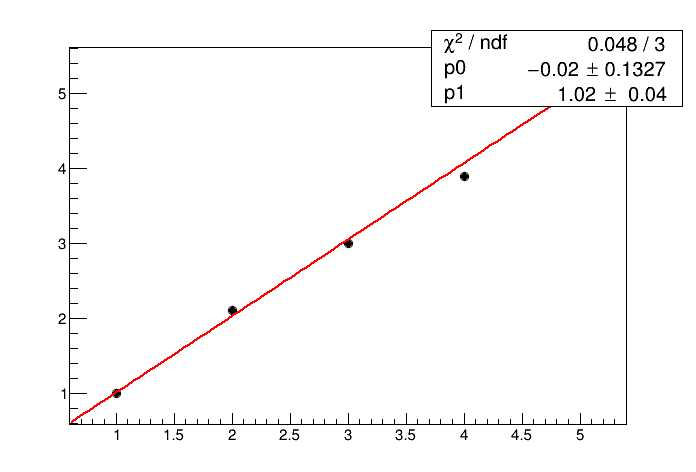


****************************************
Minimizer is Linear / Migrad
Chi2                      =        0.048
NDf                       =            3
p0                        =        -0.02   +/-   0.132665    
p1                        =         1.02   +/-   0.04        
0.048  3


In [2]:
void testRootFit(){
    TCanvas *c1 = new TCanvas;
    TGraph *g1 = new TGraph;
    g1->SetPoint(0, 1, 1.0);
    g1->SetPoint(1, 2, 2.1);
    g1->SetPoint(2, 3, 3.0);
    g1->SetPoint(3, 4, 3.9);
    g1->SetPoint(4, 5, 5.2);
    TFitResultPtr r = g1->Fit("pol1", "S");
    cout << r->Chi2() << "  " << r->Ndf() << endl;

    g1->SetMarkerStyle(20);
    g1->Draw("AP");
    gStyle->SetOptFit(1);
    c1->Draw();
}
testRootFit();

使用最小二乘法拟合

In [3]:
void testFit(){
    const int ndim = 5;
    double x[ndim]{1.0, 2.0, 3.0, 4.0, 5.0};
    double y[ndim]{1.0, 2.1, 3.0, 3.9, 5.2};
    double sumx = 0.0;
    double sumy = 0.0;
    double sumxy = 0.0;
    double sumx2 = 0.0;
    for (int i = 0; i != ndim; ++i) {
        sumx += x[i];
        sumy += y[i];
        sumxy += x[i]*y[i];
        sumx2 += x[i]*x[i];
    }
    double k = (sumxy - sumx*sumy/ndim) / (sumx2 - sumx*sumx/ndim);
    double b = (sumy - k*sumx)/(double)ndim;
    double chi = 0.0;
    for (int i = 0; i != ndim; ++i) {
        double t = y[i] - k*x[i] - b;
        chi += t * t;
    }
    printf("k = %lf, b = %lf\nchi2 = %lf, ndf = %d\n", k, b, chi, ndim-2);
}
testFit();

k = 1.020000, b = -0.020000
chi2 = 0.048000, ndf = 3


显然，结果一致，可以用最小二乘法替代root的Fit

## 优化

```c++
Double_t Tracking::simpleFit(TGraph *g, Double_t &k, Double_t &b) {
	Int_t n = g->GetN();
	Double_t sumx = 0.0;
	Double_t sumy = 0.0;
	Double_t sumxy = 0.0;
	Double_t sumx2 = 0.0;
	for (Int_t i = 0; i != n; ++i) {
		Double_t x = g->GetPointX(i);
		Double_t y = g->GetPointY(i);
		sumx += x;
		sumy += y;
		sumxy += x * y;
		sumx2 += x * x;
	}
	k = (sumxy - sumx*sumy/Double_t(n)) / (sumx2 - sumx*sumx/Double_t(n));
	b = (sumy - k*sumx) / Double_t(n);
	Double_t chi2 = 0.0;
	for (Int_t i = 0; i != n; ++i) {
		Double_t x = g->GetPointX(i);
		Double_t y = g->GetPointY(i);
		Double_t t = y - k*x - b;
		chi2 += t * t;
	}
	return chi2;
}

void Tracking::Loop(TTree *tree, bool sFit) {
	setBranch(tree);
	for (Long64_t jentry = 0; jentry != nentries; jentry++) {
      ......
		// fit part
		t = clock();
		TGraph *grx = new TGraph;
		int points = 0;
		for (int i = 0; i != 5; ++i) {
			if (trackX & 1<<i) {
				grx->SetPoint(points, xz[i], xx[i]);
				points++;
			}
		}
		c2nx = simpleFit(grx, kx, bx);
		c2nx = points == 2 ? 0.0 : c2nx / (points-2);
		for (int i = 0; i != 5; ++i) {
			fxx[i] = kx * xz[i] + bx;
			dx[i] = (trackX & 1<<i) ? xx[i] - fxx[i] : -999;
		}
		delete grx;

		TGraph* gry = new TGraph;
		points = 0;
		for (int i = 0; i != 5; ++i) {
			if (trackY & 1<<i) {
				gry->SetPoint(points, yz[i], yy[i]);
				points++;
			}
		}
		c2ny = simpleFit(gry, ky, by);
		c2ny = points == 2 ? 0.0 : c2ny / (points-2);
		for (int i = 0; i != 5; ++i) {
			fyy[i] = ky * yz[i] + by;
			dy[i] = (trackY & 1<<i) ? yy[i] - fyy[i] : -999;
		}
		delete gry;

		fitt += clock() - t;
        
      ......
	}

......
}

```

In [4]:
!../src/Tracking

0/739685


100000/739685


200000/739685


300000/739685


400000/739685


500000/739685


600000/739685


700000/739685


load time 1.204118 s


init time 0.357014 s


fit time 1.011154 s


pos time 0.315579 s


trace time 5.362049 s


fill time 7.716706 s


total time 18.004587 s


New loop time: 18.004616 s


